<a href="https://colab.research.google.com/github/SiuZheng/CT-Lung-Cancer-Detection-/blob/main/lung_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
path+= "/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
print("Path to dataset files:", path)
target_dir = "/content"
os.makedirs(target_dir, exist_ok=True)
shutil.move(path, target_dir)
moved_path = "/content/The IQ-OTHNCCD lung cancer dataset"
new_path="/content/lung_dataset"
os.rename(moved_path, new_path)
print("Moved to:", new_path)

100%|██████████| 199M/199M [00:01<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/versions/2/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset
Moved to: /content/lung_dataset


In [2]:
import random
base_path= new_path
output_base = "/content/dataset/organized_dataset"
train_ratio = 0.8

classes = {
    "Malignant cases": "malignant",
    "Bengin cases": "benign",
    "Normal cases": "normal"
}

for split in ["train", "test"]:
    for class_name in classes.values():
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

for old_folder, new_class in classes.items():
    old_path = os.path.join(base_path, old_folder)
    files = [f for f in os.listdir(old_path) if f.lower().endswith(('.jpg', '.png', '.jpeg', '.dcm'))]

    random.shuffle(files)
    split_idx = int(len(files) * train_ratio)

    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # Move train files
    for f in train_files:
        shutil.move(os.path.join(old_path, f), os.path.join(output_base, "train", new_class, f))

    # Move validation files
    for f in test_files:
        shutil.move(os.path.join(old_path, f), os.path.join(output_base, "test", new_class, f))

print("✅ Dataset reorganized into train/test folders!")

✅ Dataset reorganized into train/test folders!


In [3]:
for split in ["train", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_path = os.path.join(output_base, split)

    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        images = os.listdir(class_path)

        print(f"{class_name}: {len(images)} images")


=== TRAIN ===
benign: 96 images
normal: 332 images
malignant: 448 images

=== TEST ===
benign: 24 images
normal: 84 images
malignant: 113 images


In [4]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
IMG_SIZE = (384, 384)
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator().manual_seed(42)

train_transform = v2.Compose([
  v2.Resize(IMG_SIZE),
  v2.RandomHorizontalFlip(p=0.5),
  v2.RandomRotation(20),
  v2.RandomAffine(
  degrees=20,
  translate=(0.15, 0.15),
  scale=(0.8, 1.2)
  ),
  v2.ColorJitter(brightness=(0.7, 1.3)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
  v2.Resize(IMG_SIZE),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225])
])

train_path = "/content/dataset/organized_dataset/train"
test_path = "/content/dataset/organized_dataset/test"

base_dataset = ImageFolder(root=train_path, transform=test_transform)
train_size = int(0.85 * len(base_dataset))
val_size = len(base_dataset) - train_size
train_indices, val_indices = random_split(range(len(base_dataset)), [train_size, val_size], generator=generator)
train_dataset = torch.utils.data.Subset(base_dataset, train_indices)
train_dataset.dataset.transform = train_transform
val_dataset = torch.utils.data.Subset(base_dataset, val_indices)
test_dataset = ImageFolder(root=test_path, transform=test_transform) # Test set is fine

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_targets = np.array([base_dataset.targets[i] for i in train_dataset.indices])

class_weights = compute_class_weight(
  class_weight='balanced',
  classes=np.unique(train_targets),
  y=train_targets
)
CLASS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float).to(device)

class_names = base_dataset.classes
print("✅ Classes:", class_names)
print("✅ Class Weights:", CLASS_WEIGHTS)
print(f"✅ Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

✅ Classes: ['benign', 'malignant', 'normal']
✅ Class Weights: tensor([3.1795, 0.6359, 0.8986], device='cuda:0')
✅ Train: 744, Val: 132, Test: 221


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class AGOC(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: (B, 3, H, W)
        # Grayscale
        gray = 0.2989*x[:,0:1,:,:] + 0.5870*x[:,1:2,:,:] + 0.1140*x[:,2:3,:,:]  # (B,1,H,W)
        gray =(gray-0.450)/0.224
        # Sobel edges
        sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=x.dtype, device=x.device).view(1,1,3,3)
        sobel_y = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=x.dtype, device=x.device).view(1,1,3,3)

        edges = []
        for c in range(3):
            channel = x[:,c:c+1,:,:]
            gx = F.conv2d(channel, sobel_x, padding=1)
            gy = F.conv2d(channel, sobel_y, padding=1)
            grad = torch.sqrt(gx**2 + gy**2)
            edges.append(grad)
        edges = torch.mean(torch.cat(edges, dim=1), dim=1, keepdim=True)  # (B,1,H,W)
        mean_edges = edges.mean()
        std_edges = edges.std()
        edges = (edges - mean_edges) / std_edges
        x = torch.cat([x, gray, edges], dim=1)  # (B,5,H,W)
        return x

In [7]:
import timm

class HCTLFN(nn.Module):
    def __init__(self, n_classes=4, img_size=(384,384), trainable_cut=-120):
        super().__init__()
        self.agoc = AGOC()
        # Map 5 → 3 channels
        self.pre_conv = nn.Conv2d(5, 3, kernel_size=1, padding=0)

        # EfficientNetV2S backbone
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, features_only=True)
        # Freeze first layers
        if trainable_cut < 0:
            trainable_cut = len(self.backbone.blocks) + trainable_cut
        for i, block in enumerate(self.backbone.blocks):
            for param in block.parameters():
                param.requires_grad = i >= trainable_cut

        # Conv to reduce channels to 512 for tokens
        self.token_conv = nn.Conv2d(self.backbone.feature_info.channels()[-1], 512, kernel_size=1)

        # BiGRU for token aggregation
        self.bi_gru = nn.GRU(512, 256, batch_first=True, bidirectional=True, dropout=0.2)

        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(512, n_classes)

    def forward(self, x):
        # AGOC
        x = self.agoc(x)
        x = self.pre_conv(x)
        # EfficientNet features
        features = self.backbone(x)  # list of features
        x = features[-1]  # take last feature map (B,C,H,W)
        # Tokenization
        x = self.token_conv(x)  # (B,512,H,W)
        B, C, H, W = x.shape
        x = x.view(B, C, H*W).permute(0,2,1)  # (B, N_tokens, 512)

        # BiGRU
        x, _ = self.bi_gru(x)  # (B, N_tokens, 512)
        x = x[:, -1, :]        # Take last output (B,512)

        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [8]:
class EfficientNetClassifier(nn.Module):
      def __init__(self, n_classes=4, trainable_cut=-120):
        super().__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k',
                                          pretrained=True,
                                          features_only=True)

        if trainable_cut < 0:
            trainable_cut = len(self.backbone.blocks) + trainable_cut

        for i, block in enumerate(self.backbone.blocks):
            for param in block.parameters():
                param.requires_grad = i >= trainable_cut

        self.classifier = nn.Linear(self.backbone.feature_info.channels()[-1], n_classes)

      def forward(self, x):
          features = self.backbone(x)
          x = features[-1]
          x = x.mean(dim=[2, 3])
          x = self.classifier(x)
          return x

In [9]:
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                num_epochs=50, patience=8, save_path="best_model.pth"):
    """
    Trains a PyTorch model with early stopping and saves the best model.

    Args:
        model (nn.Module): PyTorch model to train.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        criterion: Loss function.
        optimizer: Optimizer.
        device: 'cuda' or 'cpu'.
        num_epochs (int): Maximum number of epochs.
        patience (int): Early stopping patience.
        save_path (str): Path to save best model.

    Returns:
        model: Trained model (best weights loaded).
        history: Dictionary with training/validation losses and accuracies.
    """
    best_val_acc = 0.0
    counter = 0

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_loss /= total
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * imgs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Save history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f}")
                break

    # Load best model
    model.load_state_dict(torch.load(save_path))
    return model, history

In [10]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_hctlfn = HCTLFN(n_classes=len(class_names))
optimizer = torch.optim.Adam(model_hctlfn.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss(weight=CLASS_WEIGHTS)
model_hctlfn, history_hctlfn = train_model(model_hctlfn, train_loader, val_loader,
                                           criterion, optimizer, device,
                                           num_epochs=50, patience=10,
                                           save_path="HCTLFN_best.pth")

# For plain EfficientNet
model_effnet = EfficientNetClassifier(n_classes=len(class_names))
optimizer = torch.optim.Adam(model_effnet.parameters(), lr=3e-4)
model_effnet, history_effnet = train_model(model_effnet, train_loader, val_loader,
                                           criterion, optimizer, device,
                                           num_epochs=50, patience=10,
                                           save_path="EffNet_best.pth")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Epoch 1/50 - Training: 100%|██████████| 24/24 [00:34<00:00,  1.45s/it]


Epoch 1: Train Loss=0.8508, Train Acc=0.6371, Val Loss=0.6553, Val Acc=0.8258


Epoch 2/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


Epoch 2: Train Loss=0.6003, Train Acc=0.7352, Val Loss=0.5621, Val Acc=0.8788


Epoch 3/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


Epoch 3: Train Loss=0.5854, Train Acc=0.7500, Val Loss=0.6949, Val Acc=0.7652


Epoch 4/50 - Training: 100%|██████████| 24/24 [00:35<00:00,  1.46s/it]


Epoch 4: Train Loss=0.5595, Train Acc=0.8118, Val Loss=0.5228, Val Acc=0.7727


Epoch 5/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch 5: Train Loss=0.4865, Train Acc=0.7849, Val Loss=0.5806, Val Acc=0.8409


Epoch 6/50 - Training: 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]


Epoch 6: Train Loss=0.4736, Train Acc=0.8239, Val Loss=0.5086, Val Acc=0.7576


Epoch 7/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch 7: Train Loss=0.4475, Train Acc=0.8414, Val Loss=0.4184, Val Acc=0.7955


Epoch 8/50 - Training: 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]


Epoch 8: Train Loss=0.4383, Train Acc=0.8454, Val Loss=0.4507, Val Acc=0.8030


Epoch 9/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch 9: Train Loss=0.3687, Train Acc=0.8575, Val Loss=0.6380, Val Acc=0.8636


Epoch 10/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch 10: Train Loss=0.3865, Train Acc=0.8750, Val Loss=0.4568, Val Acc=0.8030


Epoch 11/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 11: Train Loss=0.3006, Train Acc=0.9140, Val Loss=0.3501, Val Acc=0.9167


Epoch 12/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 12: Train Loss=0.2960, Train Acc=0.9167, Val Loss=0.3558, Val Acc=0.9167


Epoch 13/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 13: Train Loss=0.3233, Train Acc=0.9059, Val Loss=0.3761, Val Acc=0.8636


Epoch 14/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch 14: Train Loss=0.3162, Train Acc=0.8777, Val Loss=0.4453, Val Acc=0.8485


Epoch 15/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 15: Train Loss=0.2804, Train Acc=0.9194, Val Loss=0.3520, Val Acc=0.8939


Epoch 16/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.41s/it]


Epoch 16: Train Loss=0.2600, Train Acc=0.9086, Val Loss=0.3595, Val Acc=0.8485


Epoch 17/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 17: Train Loss=0.2440, Train Acc=0.9274, Val Loss=0.3754, Val Acc=0.8485


Epoch 18/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 18: Train Loss=0.2192, Train Acc=0.9355, Val Loss=0.2534, Val Acc=0.9091


Epoch 19/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 19: Train Loss=0.1859, Train Acc=0.9543, Val Loss=0.3446, Val Acc=0.9091


Epoch 20/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 20: Train Loss=0.2777, Train Acc=0.9113, Val Loss=0.3110, Val Acc=0.8561


Epoch 21/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


Epoch 21: Train Loss=0.2889, Train Acc=0.9274, Val Loss=0.2081, Val Acc=0.9167
Early stopping triggered at epoch 21. Best Val Acc: 0.9167


Epoch 1/50 - Training: 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]


Epoch 1: Train Loss=0.9804, Train Acc=0.7191, Val Loss=0.6650, Val Acc=0.7803


Epoch 2/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 2: Train Loss=0.3971, Train Acc=0.8750, Val Loss=0.6352, Val Acc=0.8939


Epoch 3/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 3: Train Loss=0.3069, Train Acc=0.9046, Val Loss=0.3466, Val Acc=0.9545


Epoch 4/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 4: Train Loss=0.3249, Train Acc=0.8858, Val Loss=0.3607, Val Acc=0.8939


Epoch 5/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 5: Train Loss=0.3473, Train Acc=0.9180, Val Loss=0.6885, Val Acc=0.7652


Epoch 6/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 6: Train Loss=0.2870, Train Acc=0.9167, Val Loss=0.3998, Val Acc=0.8636


Epoch 7/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 7: Train Loss=0.1967, Train Acc=0.9422, Val Loss=1.1677, Val Acc=0.9167


Epoch 8/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 8: Train Loss=0.1342, Train Acc=0.9664, Val Loss=0.2885, Val Acc=0.9015


Epoch 9/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 9: Train Loss=0.1199, Train Acc=0.9651, Val Loss=0.3476, Val Acc=0.9545


Epoch 10/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


Epoch 10: Train Loss=0.1048, Train Acc=0.9704, Val Loss=0.3225, Val Acc=0.9394


Epoch 11/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 11: Train Loss=0.0820, Train Acc=0.9798, Val Loss=0.3893, Val Acc=0.9394


Epoch 12/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 12: Train Loss=0.0782, Train Acc=0.9785, Val Loss=0.3519, Val Acc=0.9470


Epoch 13/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 13: Train Loss=0.0516, Train Acc=0.9852, Val Loss=0.3943, Val Acc=0.9621


Epoch 14/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 14: Train Loss=0.0650, Train Acc=0.9839, Val Loss=0.4920, Val Acc=0.9242


Epoch 15/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 15: Train Loss=0.0632, Train Acc=0.9839, Val Loss=0.2907, Val Acc=0.9167


Epoch 16/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 16: Train Loss=0.0762, Train Acc=0.9812, Val Loss=0.5187, Val Acc=0.9318


Epoch 17/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 17: Train Loss=0.0477, Train Acc=0.9852, Val Loss=0.1756, Val Acc=0.9773


Epoch 18/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


Epoch 18: Train Loss=0.0426, Train Acc=0.9960, Val Loss=0.0543, Val Acc=0.9924


Epoch 19/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


Epoch 19: Train Loss=0.0165, Train Acc=0.9973, Val Loss=0.0386, Val Acc=1.0000


Epoch 20/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 20: Train Loss=0.0376, Train Acc=0.9946, Val Loss=0.1273, Val Acc=0.9773


Epoch 21/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 21: Train Loss=0.0293, Train Acc=0.9892, Val Loss=0.1479, Val Acc=0.9773


Epoch 22/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 22: Train Loss=0.0128, Train Acc=0.9973, Val Loss=0.0820, Val Acc=0.9773


Epoch 23/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


Epoch 23: Train Loss=0.0225, Train Acc=0.9919, Val Loss=0.2619, Val Acc=0.9697


Epoch 24/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 24: Train Loss=0.0642, Train Acc=0.9812, Val Loss=0.4667, Val Acc=0.9091


Epoch 25/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 25: Train Loss=0.2313, Train Acc=0.9274, Val Loss=0.2213, Val Acc=0.9470


Epoch 26/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 26: Train Loss=0.1446, Train Acc=0.9637, Val Loss=0.6370, Val Acc=0.8788


Epoch 27/50 - Training: 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


Epoch 27: Train Loss=0.2155, Train Acc=0.9530, Val Loss=0.6024, Val Acc=0.9394


Epoch 28/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 28: Train Loss=0.0892, Train Acc=0.9825, Val Loss=0.4197, Val Acc=0.8939


Epoch 29/50 - Training: 100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


Epoch 29: Train Loss=0.0835, Train Acc=0.9745, Val Loss=0.2542, Val Acc=0.9773
Early stopping triggered at epoch 29. Best Val Acc: 1.0000


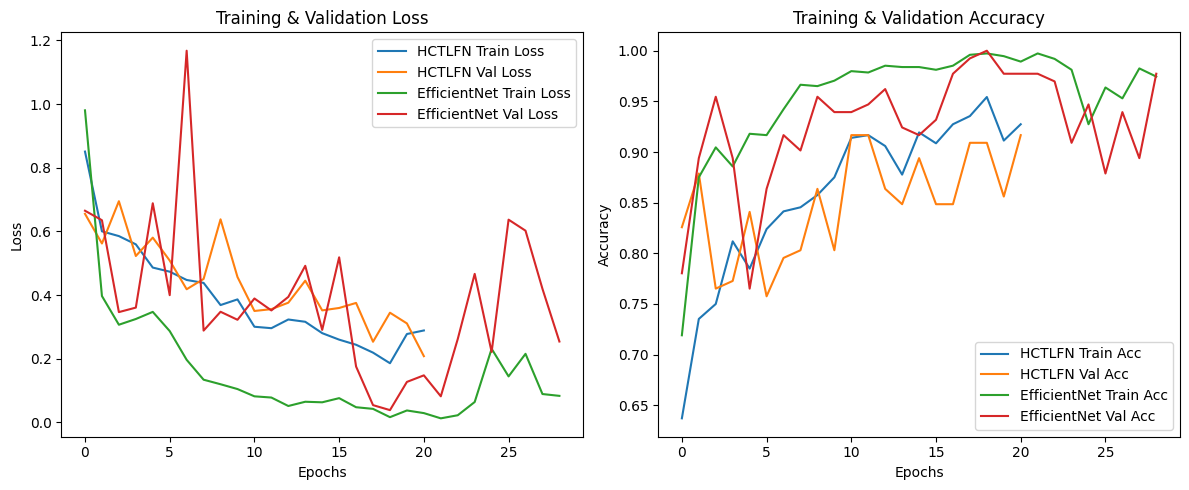

In [11]:
import matplotlib.pyplot as plt

def plot_histories(history1, history2, name1="Model 1", name2="Model 2"):
    # Loss Curve
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history1["train_loss"], label=f"{name1} Train Loss")
    plt.plot(history1["val_loss"], label=f"{name1} Val Loss")
    plt.plot(history2["train_loss"], label=f"{name2} Train Loss")
    plt.plot(history2["val_loss"], label=f"{name2} Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Accuracy Curve
    plt.subplot(1,2,2)
    plt.plot(history1["train_acc"], label=f"{name1} Train Acc")
    plt.plot(history1["val_acc"], label=f"{name1} Val Acc")
    plt.plot(history2["train_acc"], label=f"{name2} Train Acc")
    plt.plot(history2["val_acc"], label=f"{name2} Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use it:
plot_histories(history_hctlfn, history_effnet,
               name1="HCTLFN", name2="EfficientNet")

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
import numpy as np

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

In [14]:
best_hctlfn = HCTLFN(n_classes=len(class_names))
best_hctlfn.load_state_dict(torch.load("HCTLFN_best.pth", map_location=device))

evaluate_model(best_hctlfn, test_loader, class_names, device)

best_effnet = EfficientNetClassifier(n_classes=len(class_names))
best_effnet.load_state_dict(torch.load("EffNet_best.pth", map_location=device))

evaluate_model(best_effnet, test_loader, class_names, device)


Classification Report:
              precision    recall  f1-score   support

      benign       0.65      0.71      0.68        24
   malignant       1.00      1.00      1.00       113
      normal       0.91      0.89      0.90        84

    accuracy                           0.93       221
   macro avg       0.86      0.87      0.86       221
weighted avg       0.93      0.93      0.93       221

Confusion Matrix:
[[ 17   0   7]
 [  0 113   0]
 [  9   0  75]]



Classification Report:
              precision    recall  f1-score   support

      benign       0.82      0.75      0.78        24
   malignant       1.00      1.00      1.00       113
      normal       0.93      0.95      0.94        84

    accuracy                           0.95       221
   macro avg       0.92      0.90      0.91       221
weighted avg       0.95      0.95      0.95       221

Confusion Matrix:
[[ 18   0   6]
 [  0 113   0]
 [  4   0  80]]
